In [1]:
from google.colab import drive
drive.flush_and_unmount()
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
%cd "/content"

/content


In [ ]:
%pip install pandas transformers
%pip install torch
%pip install tensorflow
%pip install tf-keras
import pandas as pd
import re

from transformers import pipeline

In [4]:
tesla_tweets = pd.read_csv('tesla_and_others.csv')
print(tesla_tweets.head())

                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  


In [5]:
tesla_tweets = tesla_tweets[tesla_tweets['Stock Name'] == 'TSLA']
print(tesla_tweets.head())

                        Date  \
0  2022-09-29 23:41:16+00:00   
1  2022-09-29 23:24:43+00:00   
2  2022-09-29 23:18:08+00:00   
3  2022-09-29 22:40:07+00:00   
4  2022-09-29 22:27:05+00:00   

                                               Tweet Stock Name Company Name  
0  Mainstream media has done an amazing job at br...       TSLA  Tesla, Inc.  
1  Tesla delivery estimates are at around 364k fr...       TSLA  Tesla, Inc.  
2  3/ Even if I include 63.0M unvested RSUs as of...       TSLA  Tesla, Inc.  
3  @RealDanODowd @WholeMarsBlog @Tesla Hahaha why...       TSLA  Tesla, Inc.  
4  @RealDanODowd @Tesla Stop trying to kill kids,...       TSLA  Tesla, Inc.  


In [6]:
tesla_tweets['Tweet'] = tesla_tweets['Tweet'].apply(lambda x: re.sub(r'http\S+|www.\S+|@\w+|#\w+', '', x))
tesla_tweets['Tweet'] = tesla_tweets['Tweet'].str.lower()
tesla_tweets['Date'] = pd.to_datetime(tesla_tweets['Date']).dt.date
print(tesla_tweets['Date'].head())

0    2022-09-29
1    2022-09-29
2    2022-09-29
3    2022-09-29
4    2022-09-29
Name: Date, dtype: object


In [7]:
tesla_tweets = tesla_tweets.dropna(subset=['Tweet', 'Date']).drop_duplicates()
tesla_tweets = tesla_tweets.drop_duplicates(subset='Tweet')
tesla_tweets = tesla_tweets.drop(columns=['Stock Name', 'Company Name'], errors='ignore')
print(tesla_tweets.head())

         Date                                              Tweet
0  2022-09-29  mainstream media has done an amazing job at br...
1  2022-09-29  tesla delivery estimates are at around 364k fr...
2  2022-09-29  3/ even if i include 63.0m unvested rsus as of...
3  2022-09-29     hahaha why are you still trying to stop tes...
4  2022-09-29    stop trying to kill kids, you sad deranged o...


In [8]:
num_rows = tesla_tweets.shape[0]
start_date = tesla_tweets['Date'].min()
end_date = tesla_tweets['Date'].max()

print(f'Number of rows in the cleaned data: {num_rows}')
print(f'Start date of tweets: {start_date}')
print(f'End date of tweets: {end_date}')

Number of rows in the cleaned data: 37106
Start date of tweets: 2021-09-30
End date of tweets: 2022-09-29


In [9]:
%cd "/content/drive/MyDrive/cs7643"

/content/drive/MyDrive/cs7643


In [ ]:
# load FinBERT model for sentiment analysis
# sentiment_pipeline = pipeline('sentiment-analysis', model='yiyanghkust/finbert-tone', tokenizer='yiyanghkust/finbert-tone', device=0)
sentiment_pipeline = pipeline('sentiment-analysis', model='./finetuned_model', tokenizer='./finetuned_model', device=0)

# run sentiment classification on the 'Tweet' column in batches with truncation
sentiment_pipeline.tokenizer.model_max_length = 512
sentiment_pipeline.tokenizer.truncation = True
batch_size = 16
tweet_texts = tesla_tweets['Tweet'].tolist()

sentiment_results = []
for i in range(0, len(tweet_texts), batch_size):
    print(f'Start: i={i}')
    batch = tweet_texts[i:i + batch_size]
    sentiments = sentiment_pipeline(batch, truncation = True)
    sentiment_results.extend(sentiments)
    print(f'End: i={i}')

tesla_tweets['Sentiment'] = [result['label'] for result in sentiment_results]

In [27]:
print(tesla_tweets.head())
sentiment_counts = tesla_tweets['Sentiment'].value_counts()
print(sentiment_counts)

         Date                                              Tweet Sentiment
0  2022-09-29  mainstream media has done an amazing job at br...   LABEL_1
1  2022-09-29  tesla delivery estimates are at around 364k fr...   LABEL_1
2  2022-09-29  3/ even if i include 63.0m unvested rsus as of...   LABEL_2
3  2022-09-29     hahaha why are you still trying to stop tes...   LABEL_1
4  2022-09-29    stop trying to kill kids, you sad deranged o...   LABEL_0
Sentiment
LABEL_1    19399
LABEL_2    14036
LABEL_0     3671
Name: count, dtype: int64


In [28]:
%cd "/content"

/content


In [37]:
tesla_stock_data = pd.read_csv('tesla_historical_stock_prices.csv')
print(tesla_stock_data.head())

        Date    Open    High     Low  Close   Adj Close       Volume
0  29-Sep-22  282.76  283.65  265.78  268.21      268.21  77,620,600
1  28-Sep-22  283.08  289.00  277.57  287.81      287.81  54,664,800
2  27-Sep-22  283.84  288.67  277.51  282.94      282.94  61,925,200
3  26-Sep-22  271.83  284.09  270.31  276.01      276.01  58,076,900
4  23-Sep-22  283.09  284.50  272.82  275.33      275.33  63,748,400


In [38]:
tesla_stock_data['Date'] = pd.to_datetime(tesla_stock_data['Date'], format='%d-%b-%y')
tesla_stock_data.columns = tesla_stock_data.columns.str.strip()
tesla_stock_data = tesla_stock_data[['Date', 'Adj Close', 'Volume']].copy()
tesla_stock_data.rename(columns={'Adj Close': 'Price'}, inplace=True)
print(tesla_stock_data.head())

        Date   Price      Volume
0 2022-09-29  268.21  77,620,600
1 2022-09-28  287.81  54,664,800
2 2022-09-27  282.94  61,925,200
3 2022-09-26  276.01  58,076,900
4 2022-09-23  275.33  63,748,400


In [39]:
tesla_stock_data = tesla_stock_data.set_index('Date').asfreq('D').reset_index().interpolate()
print("Volume data after interpolation:")
print(tesla_stock_data['Volume'].head(10))


Volume data after interpolation:
0    53,868,000
1    51,094,200
2           NaN
3           NaN
4    91,449,900
5    55,297,800
6    43,898,400
7    57,587,400
8    50,215,800
9           NaN
Name: Volume, dtype: object


<ipython-input-39-9bb3e8370ff4>:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  tesla_stock_data = tesla_stock_data.set_index('Date').asfreq('D').reset_index().interpolate()


In [40]:
print(tesla_stock_data)

          Date       Price      Volume
0   2021-09-30  258.490000  53,868,000
1   2021-10-01  258.410000  51,094,200
2   2021-10-02  259.110000         NaN
3   2021-10-03  259.810000         NaN
4   2021-10-04  260.510000  91,449,900
..         ...         ...         ...
360 2022-09-25  275.783333         NaN
361 2022-09-26  276.010000  58,076,900
362 2022-09-27  282.940000  61,925,200
363 2022-09-28  287.810000  54,664,800
364 2022-09-29  268.210000  77,620,600

[365 rows x 3 columns]


In [43]:
print(tesla_stock_data['Volume'].dtypes)
print(tesla_stock_data[tesla_stock_data['Volume'].isnull()])

object
          Date       Price Volume
2   2021-10-02  259.110000    NaN
3   2021-10-03  259.810000    NaN
9   2021-10-09  262.546667    NaN
10  2021-10-10  263.263333    NaN
16  2021-10-16  284.020000    NaN
..         ...         ...    ...
346 2022-09-11  302.840000    NaN
352 2022-09-17  305.256667    NaN
353 2022-09-18  307.163333    NaN
359 2022-09-24  275.556667    NaN
360 2022-09-25  275.783333    NaN

[113 rows x 3 columns]


In [44]:
tesla_sentiment_data = tesla_tweets[['Date', 'Sentiment']]

# convert sentiment labels to numeric values
sentiment_mapping = {"LABEL_2": 1, "LABEL_1": 0, "LABEL_0": -1}
tesla_sentiment_data['sentiment_numeric'] = tesla_sentiment_data['Sentiment'].map(sentiment_mapping)
# make sure dates are in the right format
tesla_stock_data['Date'] = pd.to_datetime(tesla_stock_data['Date'])
tesla_sentiment_data['Date'] = pd.to_datetime(tesla_sentiment_data['Date'])
# aggregate sentiment scores by date (taking the average sentiment for each day)
daily_sentiment = tesla_sentiment_data.groupby('Date')['sentiment_numeric'].mean().reset_index()

daily_sentiment.rename(columns={'sentiment_numeric': 'daily_sentiment'}, inplace=True)
# interpolate missing prices
tesla_stock_data['Volume'] = tesla_stock_data['Volume'].str.replace(',', '').astype(float)
tesla_stock_data['Price'] = pd.to_numeric(tesla_stock_data['Price'], errors='coerce')

tesla_stock_data = tesla_stock_data.set_index('Date').asfreq('D')
tesla_stock_data['Volume'] = tesla_stock_data['Volume'].interpolate(method='linear', limit_direction='both')
tesla_stock_data['Price'] = tesla_stock_data['Price'].interpolate(method='linear', limit_direction='both')
tesla_stock_data = tesla_stock_data.reset_index()

In [45]:
print(tesla_stock_data)

          Date       Price      Volume
0   2021-09-30  258.490000  53868000.0
1   2021-10-01  258.410000  51094200.0
2   2021-10-02  259.110000  64546100.0
3   2021-10-03  259.810000  77998000.0
4   2021-10-04  260.510000  91449900.0
..         ...         ...         ...
360 2022-09-25  275.783333  59967400.0
361 2022-09-26  276.010000  58076900.0
362 2022-09-27  282.940000  61925200.0
363 2022-09-28  287.810000  54664800.0
364 2022-09-29  268.210000  77620600.0

[365 rows x 3 columns]


In [46]:
#tesla_stock_data = tesla_stock_data.interpolate().reset_index()
# merge Tesla stock data with sentiment data on date
merged_data = pd.merge(tesla_stock_data, daily_sentiment, on='Date', how='inner')

# Fill missing values in Volume column after merging (if any)
merged_data['Volume'] = merged_data['Volume'].fillna(merged_data['Volume'].median())

# Output the merged data
print(merged_data.head())

        Date   Price      Volume  daily_sentiment
0 2021-09-30  258.49  53868000.0         0.266667
1 2021-10-01  258.41  51094200.0         0.382979
2 2021-10-02  259.11  64546100.0         0.321739
3 2021-10-03  259.81  77998000.0         0.327869
4 2021-10-04  260.51  91449900.0         0.186441


In [47]:
%pip install scikit-learn
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data[['Price', 'Volume', 'daily_sentiment']])

In [49]:
def prepare_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:i+lookback])
        y.append(data[i+lookback, 0]) # Predicting 'Price'
    return np.array(X), np.array(y)

lookback = 7
X, y = prepare_sequences(scaled_data, lookback)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_test = torch.tensor(X_train, dtype=torch.float32), torch.tensor(X_test, dtype=torch.float32)
y_train, y_test = torch.tensor(y_train, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32)


In [50]:
# Define the Transformer model
class StockPriceTransformer(nn.Module):
    def __init__(self, input_size, num_heads, hidden_dim, num_layers, output_size, dropout=0.1):
        super(StockPriceTransformer, self).__init__()
        self.embedding = nn.Linear(input_size, hidden_dim)
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=hidden_dim, nhead=num_heads, dim_feedforward=hidden_dim * 4, dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(hidden_dim, output_size)

    def forward(self, x):
        x = self.embedding(x)  # Linear layer for initial embedding
        x = x.permute(1, 0, 2)  # Transformer expects input of shape (seq_len, batch_size, feature_size)
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # Reshape back to (batch_size, seq_len, feature_size)
        x = self.fc_out(x[:, -1, :])  # Output corresponding to the last time step
        return x
if np.any(np.isnan(X_train.numpy())) or np.any(np.isnan(y_train.numpy())):
    print("Warning: NaN values found in the training data.")
if np.any(np.isinf(X_train.numpy())) or np.any(np.isinf(y_train.numpy())):
    print("Warning: Infinity values found in the training data.")
# Hyperparameters for Transformer
input_size = 3 #X_train.shape[2]
num_heads = 8
hidden_dim = 128
num_layers = 4
output_size = 1
dropout = 0.3
learning_rate = 5e-4
num_epochs = 200

# Initialize the model, loss function, and optimizer
model = StockPriceTransformer(input_size, num_heads, hidden_dim, num_layers, output_size, dropout)
# Initialize weights explicitly for stability
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0.01)
model.apply(init_weights)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses, val_losses = [], []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output.flatten(), y_train)

    if torch.isnan(loss):
        print(f"NaN loss encountered at epoch {epoch}. Stopping training.")
        break

    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()



# Validation
    model.eval()
    with torch.no_grad():
        val_output = model(X_test)
        val_loss = criterion(val_output.flatten(), y_test)
    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item()}, Validation Loss: {val_loss.item()}')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [0/200], Loss: 1.68216073513031, Validation Loss: 45.997188568115234
Epoch [10/200], Loss: 0.5649824142456055, Validation Loss: 0.06161167845129967
Epoch [20/200], Loss: 0.27995747327804565, Validation Loss: 0.06844399869441986
Epoch [30/200], Loss: 0.14694522321224213, Validation Loss: 0.08236556500196457
Epoch [40/200], Loss: 0.089651919901371, Validation Loss: 0.0334618017077446
Epoch [50/200], Loss: 0.0727032870054245, Validation Loss: 0.04524197801947594
Epoch [60/200], Loss: 0.06899645924568176, Validation Loss: 0.04952869564294815
Epoch [70/200], Loss: 0.040426213294267654, Validation Loss: 0.03828505054116249
Epoch [80/200], Loss: 0.036479197442531586, Validation Loss: 0.02996358647942543
Epoch [90/200], Loss: 0.032627422362565994, Validation Loss: 0.03929026424884796
Epoch [100/200], Loss: 0.032774023711681366, Validation Loss: 0.027475344017148018
Epoch [110/200], Loss: 0.024783862754702568, Validation Loss: 0.032039787620306015
Epoch [120/200], Loss: 0.0252205040305852

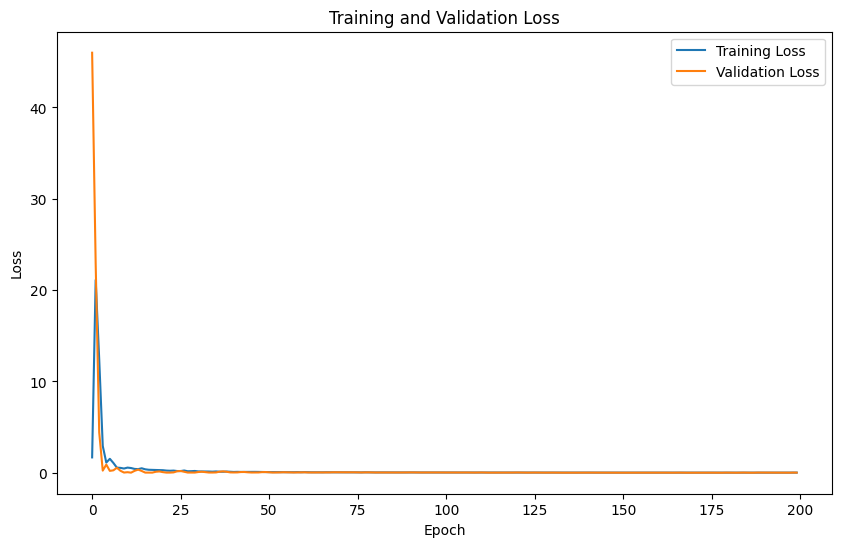

In [51]:
%pip install matplotlib
import matplotlib.pyplot as plt

def plot_transformer_training_history():
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.show()

plot_transformer_training_history()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


Future Prices: [278.48864539 283.05446864 283.61328663 279.62603185 271.15025808
 260.82498048 253.19194391]


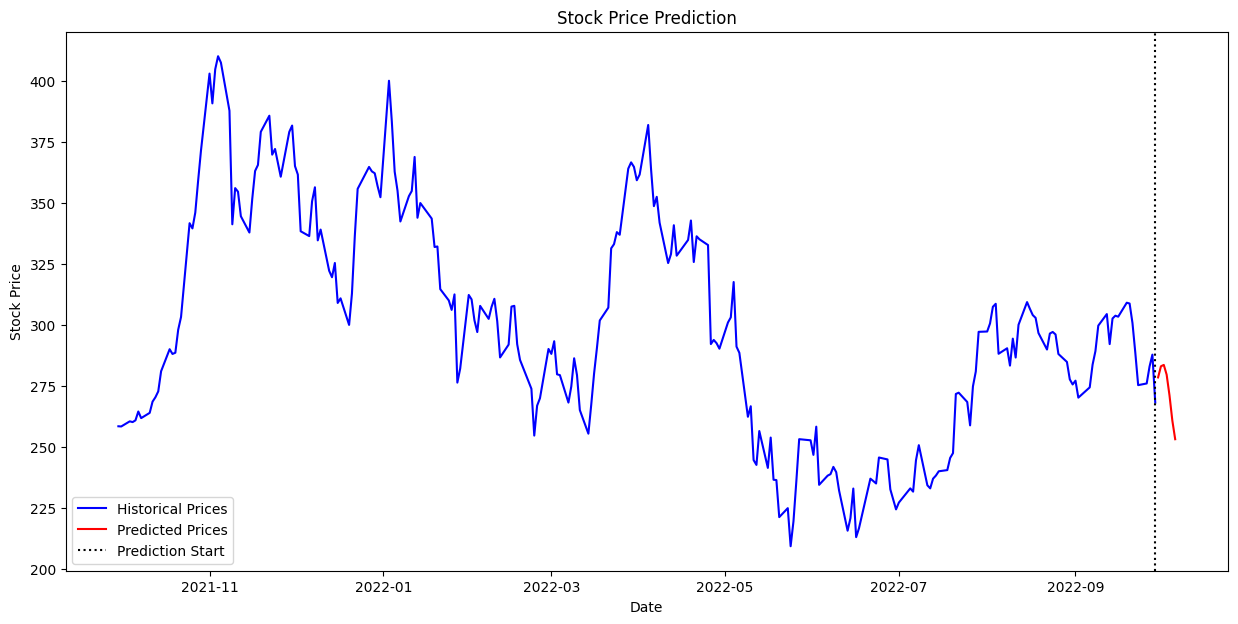

In [52]:
def predict_stock_prices(model, data, lookback, future_days):
    recent_data = data[-lookback:]
    recent_scaled = scaler.transform(recent_data)
    recent_seq = torch.tensor(recent_scaled, dtype=torch.float32).unsqueeze(0) # Shape: (1, lookback, num_features)
    model.eval()
    predictions = []
    curr_seq = recent_seq

    for _ in range(future_days):
        with torch.no_grad():
            next_price_scaled = model(curr_seq).item()
        next_price_data = np.array([[next_price_scaled, 0, 0]])
        next_price = scaler.inverse_transform(next_price_data)[0][0]
        predictions.append(next_price)

        next_data = np.array([[next_price_scaled, recent_scaled[-1, 1], recent_scaled[-1, 2]]])
        curr_seq = torch.cat((curr_seq[:, 1:, :], torch.tensor(next_data, dtype=torch.float32).unsqueeze(0)), dim=1)
    return np.array(predictions)

# Predict and plot future stock prices
future_days = 7
future_prices = predict_stock_prices(model, merged_data[['Price', 'Volume', 'daily_sentiment']].values, lookback, future_days)
print(f'Future Prices: {future_prices}')

# Plot Predictions
last_date = pd.to_datetime(merged_data['Date'].max())
future_dates = pd.date_range(start=last_date, periods=future_days + 1)[1:]

plt.figure(figsize=(15, 7))
plt.plot(merged_data['Date'], merged_data['Price'], label='Historical Prices', color='blue')
plt.plot(future_dates, future_prices, label='Predicted Prices', color='red')
plt.axvline(x=last_date, color='black', linestyle=':', label='Prediction Start')
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [56]:
def predict_stock_prices_full_range_transformer(model, data, lookback):
    """ Predict stock prices for future days using the Transformer model.

    Args:
    model (nn.Module): Trained Transformer model.
    data (pd.DataFrame): DataFrame with date, price, volume, and daily sentiment.
    lookback (int): Number of previous days to use for prediction.

    Returns: dict: A dictionary containing dates, actual prices, predicted prices, mse, and mae. """

    sentiment_data = data['daily_sentiment'].values
    price_data = data['Price'].values
    volume_data = data['Volume'].values
    dates = data['Date']

    # Scale data
    sentiment_scaler = MinMaxScaler(feature_range=(-1, 1))
    price_scaler = MinMaxScaler(feature_range=(0, 1))
    volume_scaler = MinMaxScaler(feature_range=(0, 1))

    sentiment_scaled = sentiment_scaler.fit_transform(sentiment_data.reshape(-1, 1))
    price_scaled = price_scaler.fit_transform(price_data.reshape(-1, 1))
    volume_scaled = volume_scaler.fit_transform(volume_data.reshape(-1, 1))

    # Prepare sequences for prediction
    X, y_actual = [], []
    for i in range(len(data) - lookback):
        input_seq = np.column_stack([
            price_scaled[i:i + lookback].flatten(),
            volume_scaled[i:i + lookback].flatten(),
            sentiment_scaled[i:i + lookback].flatten()
            ])
        X.append(input_seq)
        y_actual.append(price_scaled[i + lookback])

    X = np.array(X).reshape(len(X), lookback, 3)



    # Convert to tensor
    X_tensor = torch.tensor(X, dtype=torch.float32)

    # Predict using transformer model
    model.eval()
    with torch.no_grad():
        y_pred_scaled = model(X_tensor).numpy()

    # Inverse transform the scaled predictions
    y_pred = price_scaler.inverse_transform(y_pred_scaled)
    y_actual = price_scaler.inverse_transform(y_actual)

    # Calculate error metrics
    mse = np.mean((y_pred - y_actual) ** 2)
    mae = np.mean(np.abs(y_pred - y_actual))
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    mean_target = np.mean(y_actual)

    normalized_mae = mae / mean_target
    normalized_mse = mse / mean_target

    print(f"Normalized MAE: {normalized_mae:.4f}")
    print(f"Normalized MSE: {normalized_mse:.4f}")

    return {
        'dates': dates[lookback:],
        'actual_prices': y_actual.flatten(),
        'predicted_prices': y_pred.flatten(),
        'mse': mse,
        'mae': mae
    }

In [57]:
def plot_price_predictions_transformer(pred_results):
    """ Plot the historical and future stock prices predicted by the Transformer model.

    Args: pred_results (dict): A dictionary containing dates, actual prices, predicted prices, mse, and mae. """
    plt.figure(figsize=(15, 7))
    plt.plot(pred_results['dates'], pred_results['actual_prices'], label='Actual Prices', color='blue')
    plt.plot(pred_results['dates'], pred_results['predicted_prices'], label='Predicted Prices', color='red')

    plt.title('Tesla Stock Prices: Actual vs. Predicted (Transformer Model)')
    plt.xlabel('Date')
    plt.ylabel('Stock Price')
    plt.legend()

    plt.text(0.05, 0.95,
        f'Mean Squared Error: ${pred_results["mse"]: .2f}\n'
        f'Mean Absolute Error: ${pred_results["mae"]: .2f}',
        transform=plt.gca().transAxes,
        verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.show()




MSE: 1154.0903
MAE: 26.1281
Normalized MAE: 0.0870
Normalized MSE: 3.8411


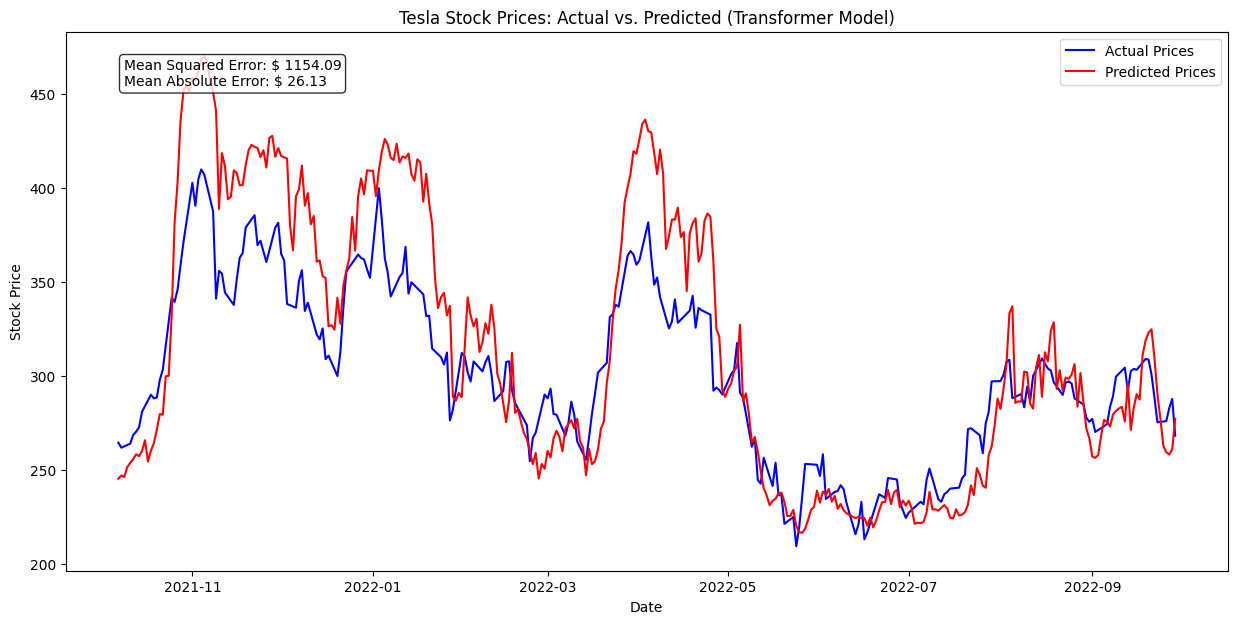

In [58]:
pred_results_transformer = predict_stock_prices_full_range_transformer(model, merged_data, lookback=7)

plot_price_predictions_transformer(pred_results_transformer)